# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

In [ ]:
pd.set_option('display.max_colwidth',200)

In [ ]:
train_dir='../data/train/audio'
SAMPLE_RATE=16000
N_FFT = 512
HOP_LENGTH=128

# Loading train data

In [ ]:
def load_train_data(path):
    tmp_list=[]
    for (dirpath, dirnames, filenames) in os.walk(path):
        for file in filenames:
            if file.endswith('.wav'):
                tmp_path=os.path.join(dirpath, file)
                class_label = tmp_path.split('/')[-2]
                data,_ = librosa.load(tmp_path,sr=SAMPLE_RATE)
                tmp_list.append([tmp_path,class_label,data])
            else:
                continue
    return  pd.DataFrame(tmp_list,columns=['file_path','class_label','data'])

In [ ]:
train_df = load_train_data(train_dir)
train_df

# Preprocessing train data

## separating noisy recordings from the rest
**noisy records** - records in folder **"_background_noise_"**

In [ ]:
noise_records_index = train_df.loc[train_df.class_label=='_background_noise_'].index
noise_df = train_df.iloc[noise_records_index].reset_index(drop=True)
train_df = train_df.drop(noise_records_index).reset_index(drop=True)
del noise_records_index

* increasing selection

In [ ]:
validation_labels =  'yes, no, up, down, left, right, on, off, stop, go'.split(', ')

In [ ]:
tmp = [col for col in train_df.class_label.unique() if col not in validation_labels]
print(tmp)

In [ ]:
# train_df.loc[~train_df.class_label.isin(validation_labels),'class_label'].count()/len(tmp)
not_val_records_increas_selec = pd.DataFrame(columns=['file_path','class_label','data'])
for label in tmp:
    selected_label_records = train_df.loc[train_df.class_label == label]
    resempled = selected_label_records.sample(n=2350,replace=True,axis=0)
    not_val_records_increas_selec = pd.concat([not_val_records_increas_selec,resempled], ignore_index=True)
    del selected_label_records, resempled
not_val_records_increas_selec

## Changing class labels

In [ ]:
# unknown records indexes
# unknown_record_index = [indx for indx in train_df.index if train_df.loc[indx,'class_label'] not in validation_labels]
# unknown_record_index = train_df.loc[train_df.class_label.isin(validation_labels)].index

In [ ]:
train_df = train_df.drop(train_df.loc[~train_df.class_label.isin(validation_labels)].index).reset_index(drop=True)
train_df.class_label.value_counts()

* Merge increased non validation records and validation records

In [ ]:
train_df = pd.concat([train_df,not_val_records_increas_selec], ignore_index=True)
display(train_df.head(3))
display(train_df.class_label.value_counts())

In [ ]:
train_df.loc[train_df.loc[~train_df.class_label.isin(validation_labels)].index,'class_label'] = 'unknown'
display(train_df.class_label.value_counts())

## Making silence records
generating new records from records in  **"_background_noise_"** folder

In [ ]:
def make_silence_records(noise_df):
    silence_df = pd.DataFrame(columns=['file_path','class_label','data'])
    for indx in noise_df.index:
        record = noise_df.loc[indx,'data']
        record_length = len(record)
        duration = int(record_length/SAMPLE_RATE)
        zeros = np.zeros(SAMPLE_RATE)
        for i in range(duration*7):
            random_sample = np.random.choice(record,SAMPLE_RATE)
            silence_df = silence_df.append(
                pd.Series([noise_df.loc[indx,'file_path'],'silence',  random_sample],
                          index=['file_path','class_label','data']),
                ignore_index=True,)  
            silence_df = silence_df.append(
                pd.Series(['own_made_silence','silence',
                           zeros],
                          index=['file_path','class_label','data']),
                ignore_index=True,)
#         silence_df = silence_df.sample(frac=1).reset_index(drop=True)
    return silence_df

In [ ]:
silence_df = make_silence_records(noise_df)
silence_df.tail()

## Making all records of the same length
* Due to some records have a duration less than 1s. I should to pad them to the same length of 1s.

In [ ]:
def pad_records_length(df):
    smaller=0
    bigger =0
    df = df.copy()
    SAMPLES_PER_TRACK= 16000
    for indx in df.index:
        record = df.loc[indx,'data']
        if len(record)<SAMPLES_PER_TRACK:
            smaller+=1
            tmp = np.zeros(SAMPLES_PER_TRACK)
            tmp[:record.shape[0]]=record
            df.loc[indx,'data']= tmp
            del tmp
        elif len(record)>SAMPLES_PER_TRACK:
            bigger+=1
            df.loc[indx,'data']= record[:SAMPLES_PER_TRACK]   
    print(f'Record {bigger} - bigger than 1s\nRecords smaller then 1s = {smaller}')
    return df

In [ ]:
train_df = pad_records_length(train_df)

# Data Augmentation

* center records

In [ ]:
def center_records(data,sr=16000):
    df = data.copy()
    df['centered'] = None
    half = sr//2
    for indx in tqdm(df.index):
        data = df.loc[indx,'data']
        center = np.argmax(data)
        if center<half:
            shift = int(half-center)
            centered_data = np.roll(data, shift)
        elif center>half:
            shift = int(half-center)
            centered_data = np.roll(data, shift)
        df.at[indx,'centered'] = centered_data
    return df

In [ ]:
train_df=center_records(train_df)
train_df.head(2)

## Finding records that do not match their class

In [ ]:
def is_bad_audio(df,column_name = 'data'):
    df = df.copy()
    df['is_bad'] = None
    for indx in df.index:
        data = df.loc[indx,column_name]
        features=librosa.feature.spectral_centroid(y=data,sr=16000,n_fft=512,hop_length=128)[0]
        m = np.mean(features)
        t = np.std(features)
        if  t < 80:
            # silent
            df.loc[indx,'is_bad']='silent'
        elif (m > 2550 and t < 300):
            # noisy
            df.loc[indx,'is_bad']='noise'
        elif (m > 3500 and t > 1200):
            # distorted
            df.loc[indx,'is_bad']='distorted'
        else:
            df.loc[indx,'is_bad']='good'
    return df

In [ ]:
train_df = is_bad_audio(train_df)
display(train_df.head(1))
display(train_df.is_bad.value_counts())

### Working with not matched records

In [ ]:
#  changing noise records to silent class all distorted to unknown and dropping silent 
distorted_indx = train_df.loc[train_df.is_bad=='distorted'].index
noise_indx = train_df.loc[train_df.is_bad=='noise'].index
silent_indx = train_df.loc[train_df.is_bad=='silent'].index

In [ ]:
train_df.loc[[*distorted_indx,*silent_indx],'class_label'] = 'unknown'
train_df.loc[noise_indx,'class_label'] = 'silence'
# train_df = train_df.drop(silent_indx).reset_index(drop=True)

In [ ]:
train_df.class_label.value_counts()

In [ ]:
# selected manually
silent = "../data/train/audio/stop/1fd85ee4_nohash_0.wav"

wrong_words = ['../data/train/audio/right/46a153d8_nohash_4.wav',
               '../data/train/audio/down/c9b653a0_nohash_1.wav',
               '../data/train/audio/dog/94de6a6a_nohash_0.wav']

bad_records = ['../data/train/audio/on/99b05bcf_nohash_0.wav',
               '../data/train/audio/up/a13e0a74_nohash_0.wav',
               '../data/train/audio/no/e5dadd24_nohash_0.wav']

In [ ]:
train_df.loc[train_df.file_path.isin([*wrong_words,*bad_records]),'class_label'] = 'unknown'
train_df.loc[train_df.file_path=='silent','class_label'] = 'silence'

# Merge silence dataframe and train dataframe

In [ ]:
merged_df = pd.concat([train_df,silence_df], ignore_index=True)
merged_df.head(2)

* Silence records wasn't centered that's why there are have not in centered column and thats should be changed because in future i'll use it.

In [ ]:
# change records  with none values in centered column to data column values
centered_nan_index = merged_df.loc[merged_df.centered.isna()==True].index
merged_df.loc[centered_nan_index,'centered'] = merged_df.loc[centered_nan_index,'data']
merged_df.tail()

# Create features

* Mel Spectrograms

In [ ]:
def create_mel_spec_features(data,column_name = 'data'):
    df = data.copy()
    df['mel_spec'] = None
    for indx in tqdm(df.index):
        mel_spec = librosa.feature.melspectrogram(df.loc[indx,column_name],sr=16000,n_fft=512,hop_length=128,n_mels=90)
        log_mel_spec = librosa.power_to_db(mel_spec)
        df.loc[indx,'mel_spec'] = [log_mel_spec]
    return df

In [ ]:
merged_df_with_mel =create_mel_spec_features(merged_df)

# Train validation test split

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(merged_df_with_mel, test_size=0.3,random_state=21)

# Defining feature and target variables

* Train

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
encoder = LabelEncoder()

In [ ]:
X_train = np.array([rec for rec in train['mel_spec']])

In [ ]:
y_train = train.class_label.values
y_train = encoder.fit_transform(y_train)

classes_encoded = encoder.classes_
num_classes = len(classes_encoded)
print(num_classes)

In [ ]:
y_train = to_categorical(y_train,num_classes = num_classes)

* Test

In [ ]:
X_test = np.array([rec for rec in test['mel_spec']])
y_test = test.class_label.values
y_test = encoder.transform(y_test)
y_test = to_categorical(y_test,num_classes = num_classes)

* Reshapping features data

In [ ]:
# Reshape for mel spec features
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2],1))

# Building model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D,AveragePooling2D, MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Conv2D(8, 2, padding='valid',activation='relu', input_shape=X_train.shape[1:]))
for i in range(2):
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(8, 2, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, 3, activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
model.fit(X_train,y_train, batch_size=64, epochs=25, validation_data=(X_val,y_val),callbacks=[es, mc]) 

* Loading best saved model

In [ ]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

* Making test prediction

In [ ]:
prediction = saved_model.predict(X_test)

* Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
pred = [classes_encoded[np.argmax(p)] for p in prediction]
true_val = [classes_encoded[np.argmax(p)] for p in y_test]

In [ ]:
print(classification_report(true_val, pred, target_names=classes_encoded))

In [ ]:
from my_module import plot_confusion_matrix
plot_confusion_matrix(confusion_matrix(true_val, pred),classes_encoded,normalize=False)

# Submition predition

* Load submission data

In [ ]:
test_dir = '../data/test'
def load_test_data(path):    
    tmp_list=[]
    for (dirpath, dirnames, filenames) in os.walk(path):
        for file in filenames:
            if file.endswith('.wav'):
                tmp_path=os.path.join(dirpath, file)
                data,_ = librosa.load(tmp_path,sr=SAMPLE_RATE)
                tmp_list.append([file,data])
            else:
                continue
    return  pd.DataFrame(tmp_list,columns=['file_path','data'])

In [ ]:
test_data = load_test_data(test_dir)

* preprocess

In [ ]:
test_data = pad_records_length(test_data)

In [ ]:
test_data = center_records(test_data)

In [ ]:
test_data = create_mel_spec_features(test_data, column_name='centered')

In [ ]:
X_sub = np.array([rec for rec in test_data.mel_spec])
X_sub = np.reshape(X_sub,(X_sub.shape[0],X_sub.shape[1],X_sub.shape[2],1))

In [ ]:
prediction_for_sub = saved_model.predict(X_sub)

In [ ]:
fname = test_data.file_path.values

In [ ]:
classes_encoded = 'down go left no off on right silence stop unknown up yes'.split()
sub_prediction =[classes_encoded[np.argmax(p)] for p in prediction_for_sub]

* make pandas dataframe and save to csv file

In [ ]:
submission_df = pd.DataFrame(list(zip(fname,sub_prediction)),columns=['fname','label'])
submission_df.to_csv('submission.csv',index=False)

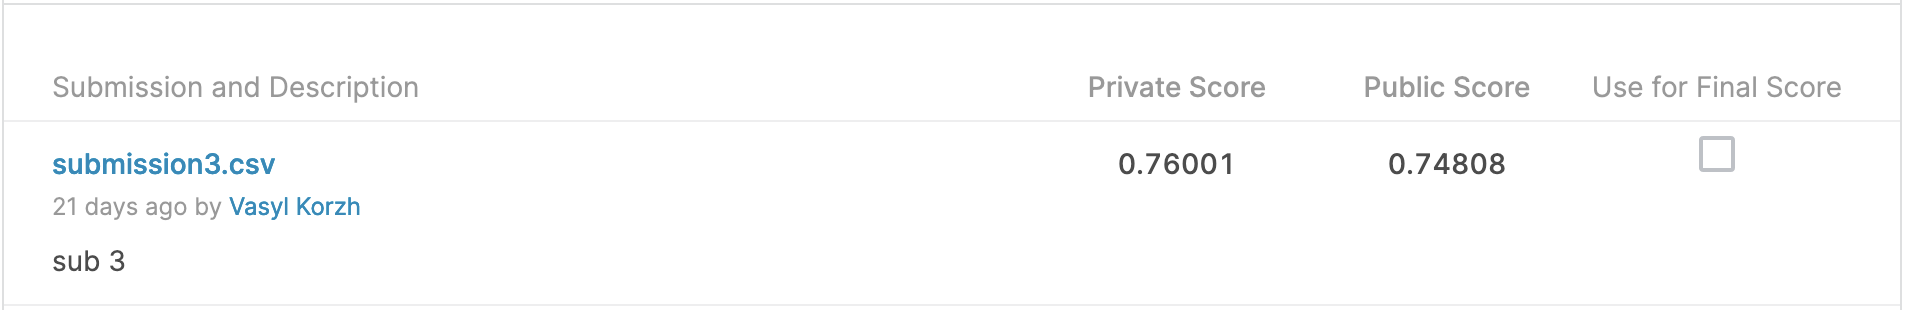